# Sandbox Notebook

This notebook is used for testing and debuging various code snippets and functionalities that are used within the P7.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import clip
from PIL import Image

In [2]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
import torch
import clip
from PIL import Image
from torch import nn
import numpy as np

self_logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device)

image = Image.open("data/Unconditional/shapes32/Circle_5da41627-7cb2-11ee-9f7a-f4c88a780d10.png")
plt.imshow(image)

image = preprocess(image).unsqueeze(0).to(device)
print(image.shape)
text = clip.tokenize(["a triangle", "a rectangle", "a circle", "a ellipse"]).to(device)
text = clip.tokenize(["white", "red", "blue", "green"]).to(device)


with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    image_features = image_features / image_features.norm(dim=1, keepdim=True)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    logit_scale = self_logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # print("logits_per_image", logits_per_image, "logits_per_text", logits_per_text)
    print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    # print("logits_per_image", logits_per_image, "logits_per_text", logits_per_text)
    print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

FileNotFoundError: [Errno 2] No such file or directory: 'data/Unconditional/shapes32/Circle_5da41627-7cb2-11ee-9f7a-f4c88a780d10.png'

In [ ]:
import os
import torch
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
import pandas as pd


class ImageSentenceDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, captions_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        df = pd.read_csv(captions_file, header=None, names=["image_files", "captions"])
        self.image_files = df["image_files"].tolist()
        self.captions = df["captions"].tolist()
        
    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        filename = self.image_files[idx]
        caption = self.captions[idx]
        image = Image.open(os.path.join(self.root_dir, filename))
        if self.transform:
            image = self.transform(image)
        return image, caption
    

def get_data(args):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(20),
        torchvision.transforms.RandomResizedCrop(args["image_size"], scale=(0.8, 1.0)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = ImageSentenceDataset(root_dir=args["dataset_path"], captions_file=args["captions_file"], transform=transforms)
    dataloader = DataLoader(dataset, batch_size=args["batch_size"], shuffle=True)
    return dataloader



args=dict()
args["batch_size"] = 8
args["dataset_path"] = "data/Unconditional/shapes32"
args["captions_file"] ="data/Unconditional/prompts.csv"
args["image_size"] = 32
dataloader = get_data(args=args)

images, captions = next(iter(dataloader))

images.shape, captions

FileNotFoundError: [Errno 2] No such file or directory: 'data/Unconditional/prompts.csv'

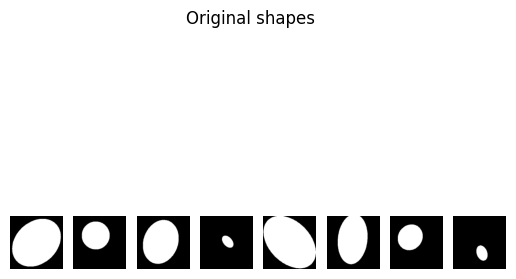

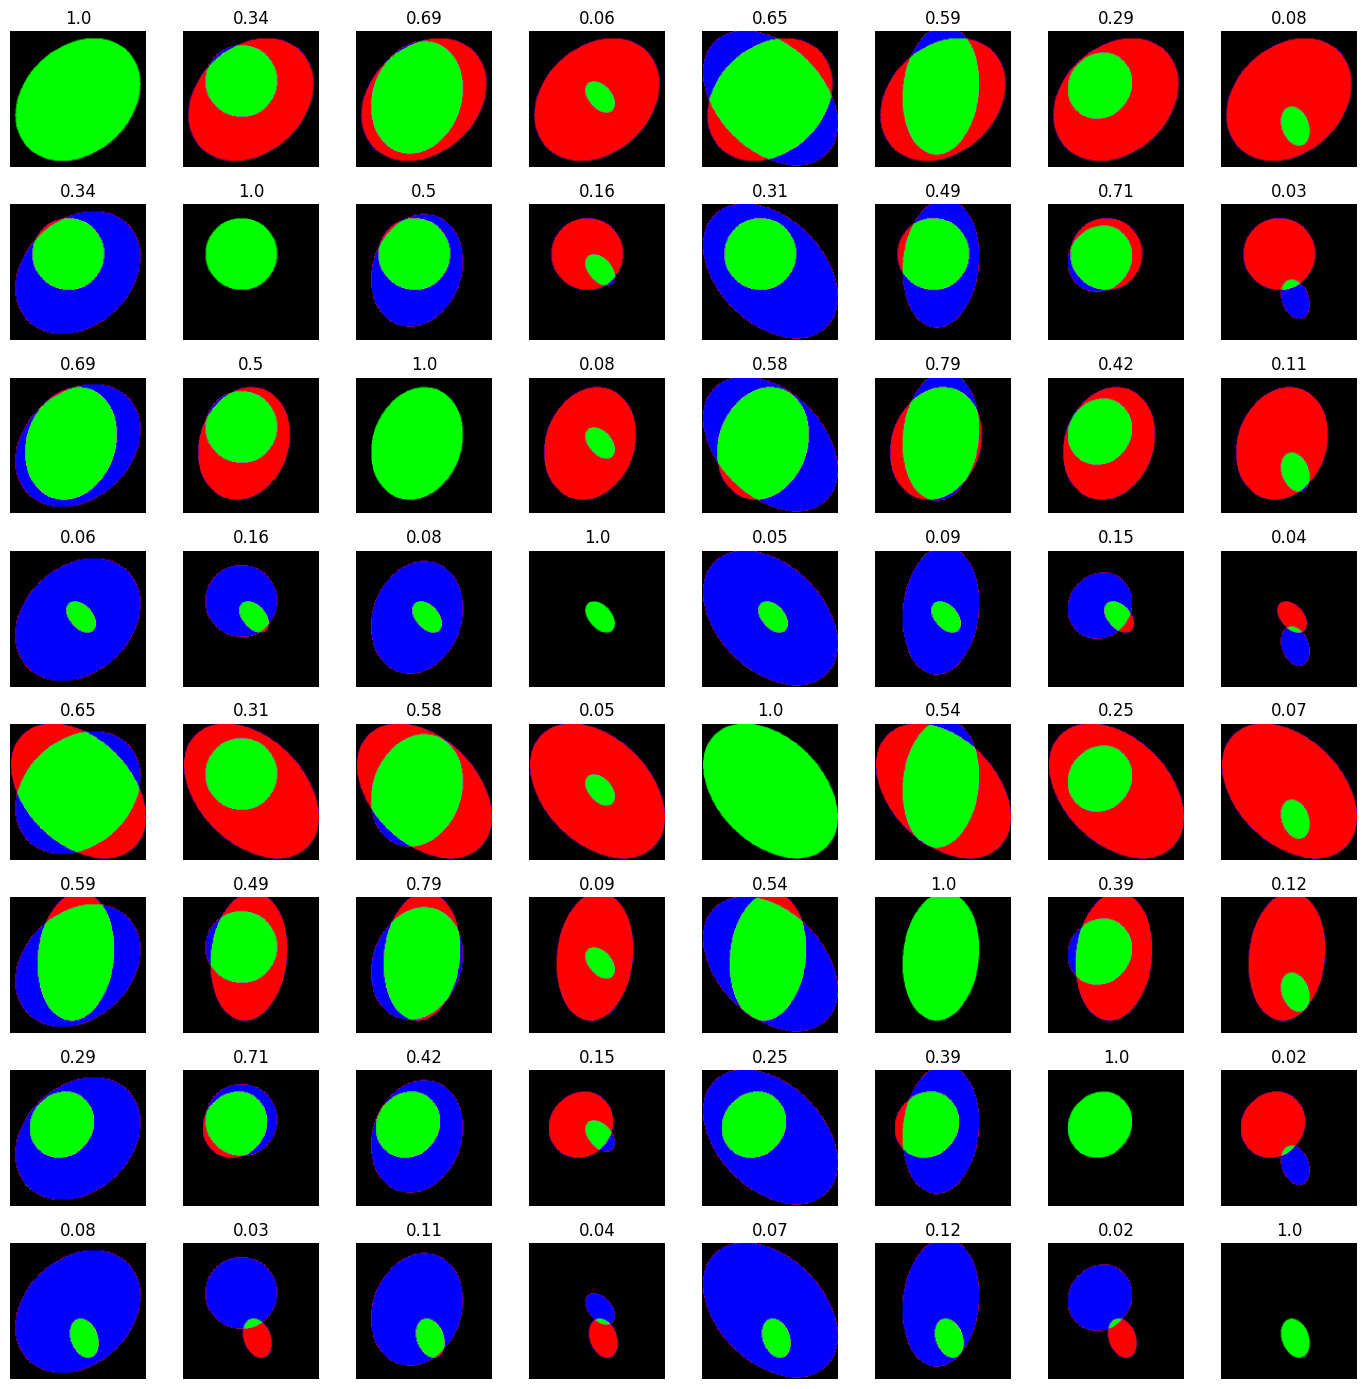

In [ ]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

from utils.metrics import CLIPMetrics, binary_iou


path = "./data/test128/images"
image_files = [file for file in os.listdir(path) if re.match(r'^.*\.(jpg|png)$', file)]
images = [cv2.imread(os.path.join(path, file)) for file in image_files]
images = images[0:8]

fig, ax = plt.subplots(1, len(images))

for idx, image in enumerate(images):
    ax[idx].imshow(image)
    ax[idx].axis('off')
plt.suptitle("Original shapes")
plt.show()

fig, ax = plt.subplots(len(images), len(images), figsize=(14, 14))

for i, image1 in enumerate(images):
    for j, image2 in enumerate(images):
        image = np.zeros_like(image1)
        image[:, :, 0] = image1[:, :, 0] - image2[:, :, 0] 
        image[:, :, 1] = image1[:, :, 0] & image2[:, :, 0]
        image[:, :, 2] = image2[:, :, 0] - image1[:, :, 0]
        iou = binary_iou(image1, image2)
        ax[i, j].imshow(image)
        ax[i, j].set_title(np.round(iou, 2))
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

[[0.11213852 0.07795274 0.00902594 0.0451118  0.08017558 0.1274818
  0.09299856 0.43899697 0.01611803]]
[[0.42311776 0.03309415 0.01164631 0.16231544 0.0435741  0.18653907
  0.10992306 0.01768441 0.01210579]]
[[0.03026534 0.00512051 0.0013457  0.7205815  0.03899913 0.18177848
  0.01582252 0.00523152 0.00085535]]
[[0.14939876 0.07829947 0.0115667  0.05090226 0.03580677 0.26358542
  0.22500591 0.15905932 0.02637543]]
[[0.2941956  0.03869362 0.00761763 0.21763407 0.08252552 0.2124961
  0.11502773 0.02219671 0.00961297]]
[[0.22025293 0.0797997  0.00516806 0.25199294 0.04444641 0.11875729
  0.23981395 0.02085733 0.01891126]]
[[0.13532348 0.51926565 0.00559917 0.1071694  0.11541806 0.03396798
  0.03828473 0.03517542 0.00979618]]
[[0.42029065 0.01610215 0.00420843 0.19279082 0.02876033 0.13739508
  0.17487203 0.00873632 0.0168443 ]]
[[0.6342421  0.04115401 0.00452816 0.05076301 0.02874806 0.03204986
  0.1594949  0.02625075 0.02276919]]


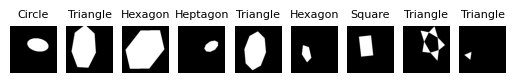

In [ ]:
from PIL import Image
cm = CLIPMetrics()


images = [cv2.imread(os.path.join(path, file)) for file in image_files]


labels = ["Triangle",
          "Square",
          "Pentagon",
          "Hexagon",
          "Octagon",
          "Heptagon",
          "Nonagon",
          "Circle",
          "Star",
          ]


fig, ax = plt.subplots(1, len(images))

for idx, image in enumerate(images):
    results = cm.predict_shape(Image.fromarray(image), labels)
    print(results)
    ax[idx].imshow(image)
    ax[idx].set_title(labels[np.argmax(results)], size=8)
    ax[idx].axis('off')
plt.show()

In [ ]:
import pandas as pd

def create_label_subset(path, n_per_class=5):
    df = pd.read_csv(os.path.join(path, "labels.csv"))
    df = df.groupby("shape_name").head(n_per_class)
    df.to_csv(os.path.join(path, f"labels_{n_per_class}.csv"), index=False)

path = "data/test32/"
create_label_subset(path, n_per_class=2)

In [5]:
import cv2
import matplotlib.pyplot as plt
image = cv2.imread('../data/test/image/Circle_de1c30e1-86fe-11ee-8812-f4c88a780d10.png')
image.shape
plt.imshow(image)

AttributeError: 'NoneType' object has no attribute 'shape'

### Wandb Examples

In [6]:
import wandb

class WandbTable:
    
    def __init__(self):
        self.data = []
        self.columns = set()
        self.table = None

    def add_data(self, data_dict):
        self.data.append(data_dict)
        self.columns.update(data_dict.keys())

    def get_table(self):
        self.table = wandb.Table(columns=list(self.columns))
        for data_dict in self.data:
            row = [data_dict.get(col, None) for col in self.columns]
            self.table.add_data(*row)
        return self.table
    

# # Initialize a new run
# run = wandb.init(project="my-project", name="my-run")

# Create a new WandbTable
my_table = WandbTable()

# Add data to the table
my_table.add_data({"column1": "value1", "column2": "value2", "column3": "value3"})
my_table.add_data({"column1": "value4", "column2": "value5", "column4": "value6"})

# Log the table
run.log({"my-table": my_table.get_table()})



NameError: name 'run' is not defined

## Center distance

In [8]:
from utils.metrics import center_distance_pytorch, batch_center_of_mass
from dataset import ImageSentenceDataset
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(80),  # args.image_size + 1/4 *args.image_size 80 for args.image_size = 64 ????
            torchvision.transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])


val_dataset   = ImageSentenceDataset("data/test32/labels.csv", transform=transforms)

dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [11]:
images, condition, filenames = next(iter(dataloader))

images = images.to("cuda")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


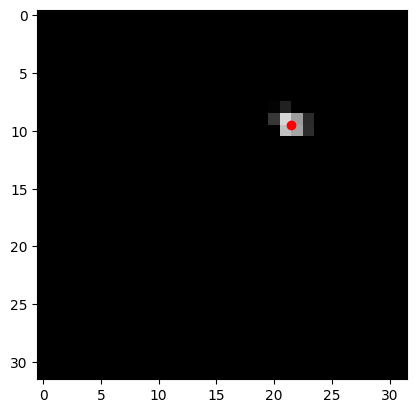

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


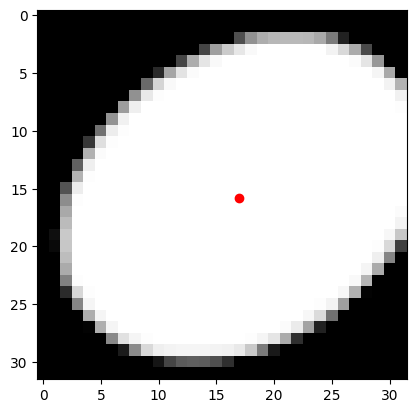

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


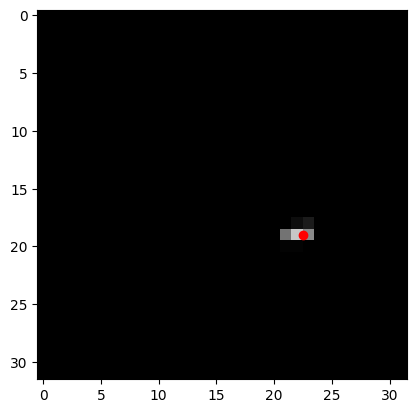

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


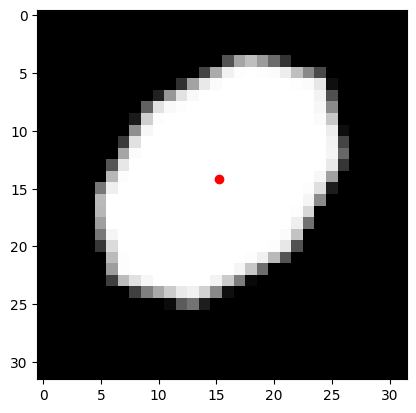

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


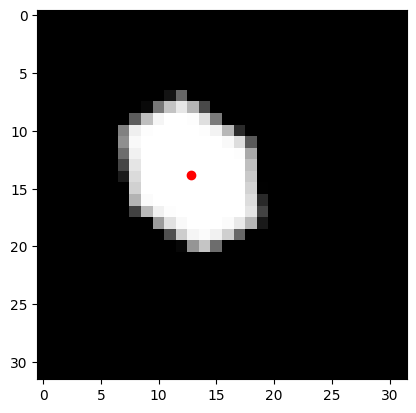

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


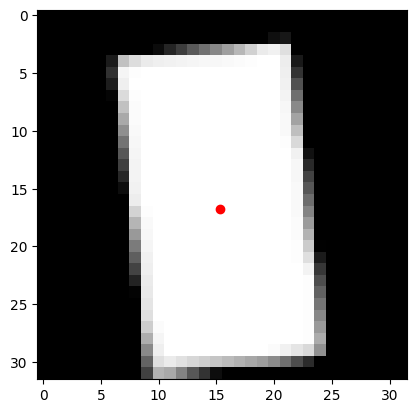

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


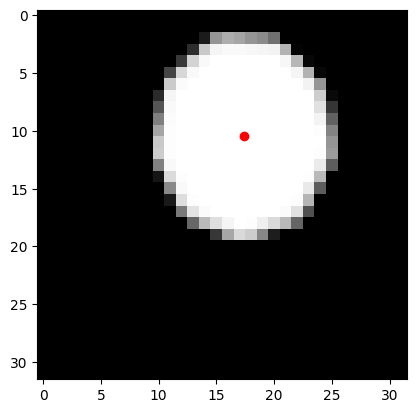

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


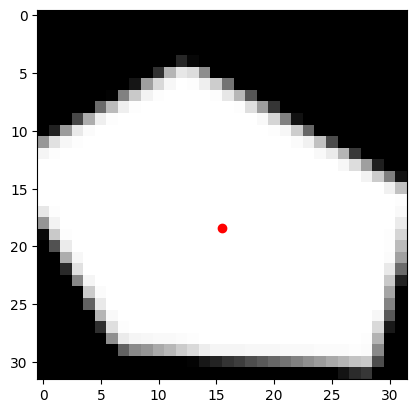

In [15]:
centers = batch_center_of_mass(images > 0.5)

for i, center in enumerate(centers):
    center = center.cpu().numpy()
    plt.imshow(images[i,:,:,:].permute(1, 2, 0).cpu())
    plt.plot( center[1], center[0], "ro")
    plt.show()

In [11]:
batch_center_of_mass(images > .5)

tensor([[16.5294, 18.1176],
        [16.9042, 12.1853],
        [ 7.1600, 12.9600],
        [17.5196, 14.0810],
        [19.0000, 22.0000],
        [15.1867, 13.5600],
        [17.9492, 12.6949],
        [12.3846, 10.8671]])

In [8]:
center_distance_pytorch(images[0:4], images[4:8])

tensor([ 4.6018,  2.1999, 10.7924,  6.0578])